In [65]:
%matplotlib inline

import pandas
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.cross_validation import KFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn import cross_validation
import numpy as np
import matplotlib.pyplot as plt
import re
import operator

# First trial

## Read data

In [66]:
titanic = pandas.read_csv("train.csv")
# Print the first 5 rows of the dataframe
print(titanic.head(5))
print(titanic.describe())

   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S  
  

C:\Users\DaSom\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3834: RuntimeWarning: Invalid value encountered in percentile
  RuntimeWarning)


## Replace missing values 

In [67]:
titanic["Age"] = titanic["Age"].fillna(titanic["Age"].median())

## Convert non-numeric to numeric values

In [68]:
# Find all the genders 
print(titanic["Sex"].unique())
titanic.loc[titanic["Sex"] == "male", "Sex"] = 0
titanic.loc[titanic["Sex"] == "female", "Sex"] = 1

['male' 'female']


In [69]:
# Find all "Embarked"
print(titanic["Embarked"].unique())
titanic["Embarked"] = titanic["Embarked"].fillna("S")
titanic.loc[titanic["Embarked"] == "S", "Embarked"] = 0
titanic.loc[titanic["Embarked"] == "C", "Embarked"] = 1
titanic.loc[titanic["Embarked"] == "Q", "Embarked"] = 2

['S' 'C' 'Q' nan]


## Linear Regression and Cross Validation

In [70]:
# predict the target
predictors = ["Pclass", "Sex", "Age", "SibSp", "Parch", "Fare", "Embarked"]

# Initialize the algorithm 
alg = LinearRegression()
# Generate cross validation folds 
# Set random_state to get the same splits
kf = KFold(titanic.shape[0], n_folds=3, random_state=1)

predictions = []
for train, test in kf:
    # Take the rows in the train folds
    train_predictors = (titanic[predictors].iloc[train,:])
    # The target used to train the algorithm
    train_target = titanic["Survived"].iloc[train]
    # Train the algorithm using the predictors and target
    alg.fit(train_predictors, train_target)
    # Make predictions on the test fold
    test_predictions = alg.predict(titanic[predictors].iloc[test,:])
    predictions.append(test_predictions)
# Concatenate three separate numpy arrays into one 
# Axis 0
predictions = np.concatenate(predictions, axis=0)

##  Percentage of correct predictions

In [71]:
# Map predictions to outcomes 
predictions[predictions > .5] = 1
predictions[predictions <=.5] = 0
accuracy = sum(map(lambda x, y: x == y, predictions, titanic["Survived"]))/len(titanic["Survived"])
print(accuracy)

0.783389450056


## Logistic Regression

In [72]:
# Initialize the algorithm
alg = LogisticRegression(random_state=1)
# Compute the accuracy score
scores = cross_validation.cross_val_score(alg, titanic[predictors], titanic["Survived"], cv=3)
# Take the mean of the scores 
print(scores.mean())

0.787878787879


## Test data

In [73]:
titanic_test = pandas.read_csv("test.csv")
titanic_test["Age"] = titanic_test["Age"].fillna(titanic["Age"].median())
titanic_test["Fare"] = titanic_test["Fare"].fillna(titanic_test["Fare"].median())
titanic_test.loc[titanic_test["Sex"] == "male", "Sex"] = 0 
titanic_test.loc[titanic_test["Sex"] == "female", "Sex"] = 1
titanic_test["Embarked"] = titanic_test["Embarked"].fillna("S")

titanic_test.loc[titanic_test["Embarked"] == "S", "Embarked"] = 0
titanic_test.loc[titanic_test["Embarked"] == "C", "Embarked"] = 1
titanic_test.loc[titanic_test["Embarked"] == "Q", "Embarked"] = 2

## Submission

In [74]:
# Initialize the algorithm 
alg = LogisticRegression(random_state=1)

# Train the algorithm using all the training data
alg.fit(titanic[predictors], titanic["Survived"])

# Make predictions 
predictions = alg.predict(titanic_test[predictors])

# Submission
submission = pandas.DataFrame({
        "PassengerId": titanic_test["PassengerId"],
        "Survived": predictions
    })
submission.to_csv("kaggle.csv", index=False)

In [75]:
# Result: About 79% of accuracy achieved

# Second trial with improvements

## Random forest and cross validation

In [76]:
# Currently, I get 75% accuracy. Let's try to improve this

predictors = ["Pclass", "Sex", "Age", "SibSp", "Parch", "Fare", "Embarked"]

# Initialize the algorithm with the default paramters
# n_estimators is the number of trees I want to make
# min_samples_split is the minimum number of rows I need to make a split
# min_samples_leaf is the minimum number of samples I can have at the place where a tree branch ends 
alg = RandomForestClassifier(random_state=1, n_estimators=10, min_samples_split=2, min_samples_leaf=1)

# Compute the accuracy score  
kf = cross_validation.KFold(titanic.shape[0], n_folds=3, random_state=1)
scores = cross_validation.cross_val_score(alg, titanic[predictors], titanic["Survived"], cv=kf)

# Take the mean of the scores
print(scores.mean())

0.785634118967


## Reduce overfitting

In [77]:
# Increase the number of trees 
alg = RandomForestClassifier(random_state=1, n_estimators=50, min_samples_split=4, min_samples_leaf=2)

# Compute the accuracy score 
kf = cross_validation.KFold(titanic.shape[0], 3, random_state=1)
scores = cross_validation.cross_val_score(alg, titanic[predictors], titanic["Survived"], cv=kf)

# Take the mean of the scores 
print(scores.mean())

0.81593714927


## Generate new features

In [78]:
# Generate new features using 1) the length of the name and 2) the total number of people in a family
titanic["FamilySize"] = titanic["SibSp"] + titanic["Parch"]
titanic["NameLength"] = titanic["Name"].apply(lambda x: len(x))

## Map each title to an integer value

In [79]:
# A function to get the title from a name
def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    if title_search:
        return title_search.group(1)
    return ""

titles = titanic["Name"].apply(get_title)
print(pandas.value_counts(titles))

Mr          517
Miss        182
Mrs         125
Master       40
Dr            7
Rev           6
Major         2
Mlle          2
Col           2
Ms            1
Don           1
Sir           1
Countess      1
Capt          1
Lady          1
Mme           1
Jonkheer      1
Name: Name, dtype: int64


In [80]:
# Map each title to an integer.  Some titles are very rare so, compressed into the same codes as other titles
title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Dr": 5, "Rev": 6, "Major": 7, "Col": 7, "Mlle": 8, "Mme": 8, "Don": 9, "Lady": 10, "Countess": 10, "Jonkheer": 10, "Sir": 9, "Capt": 7, "Ms": 2}
for k,v in title_mapping.items():
    titles[titles == k] = v

print(pandas.value_counts(titles))

titanic["Title"] = titles

1     517
2     183
3     125
4      40
5       7
6       6
7       5
10      3
8       3
9       2
Name: Name, dtype: int64


## Map each last name to a family ID

In [81]:
# A dictionary mapping family name to id
family_id_mapping = {}

def get_family_id(row):
    last_name = row["Name"].split(",")[0]
    family_id = "{0}{1}".format(last_name, row["FamilySize"])
    if family_id not in family_id_mapping:
        if len(family_id_mapping) == 0:
            current_id = 1
        else:
            current_id = (max(family_id_mapping.items(), key=operator.itemgetter(1))[1] + 1)
        family_id_mapping[family_id] = current_id
    return family_id_mapping[family_id]

family_ids = titanic.apply(get_family_id, axis=1)

In [82]:
# compress all of the families under 3 members into one code
family_ids[titanic["FamilySize"] < 3] = -1
print(pandas.value_counts(family_ids))
titanic["FamilyId"] = family_ids

-1      800
 14       8
 149      7
 63       6
 50       6
 59       6
 17       5
 384      4
 27       4
 25       4
 162      4
 8        4
 84       4
 340      4
 43       3
 269      3
 58       3
 633      2
 167      2
 280      2
 510      2
 90       2
 83       1
 625      1
 376      1
 449      1
 498      1
 588      1
dtype: int64


## Univariate feature selection

In [83]:
# find the best feature
predictors = ["Pclass", "Sex", "Age", "SibSp", "Parch", "Fare", "Embarked", "FamilySize", "Title", "FamilyId", "NameLength"]

# Perform feature selection
selector = SelectKBest(f_classif, k=5)
selector.fit(titanic[predictors], titanic["Survived"])

SelectKBest(k=5, score_func=<function f_classif at 0x000001D239E048C8>)

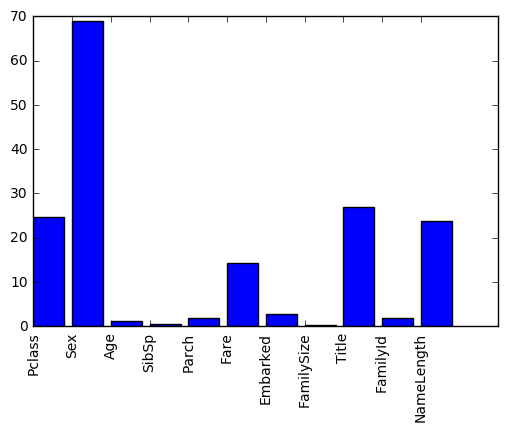

In [84]:
# Get the raw p-values for each feature, and transform from p-values into scores
scores = -np.log10(selector.pvalues_)
plt.bar(range(len(predictors)), scores)
plt.xticks(range(len(predictors)), predictors, rotation='vertical')
plt.show()

In [85]:
# Pick only the four best features
predictors = ["Pclass", "Sex", "Fare", "Title"]
alg = RandomForestClassifier(random_state=1, n_estimators=50, min_samples_split=8, min_samples_leaf=4)

# Compute the accuracy score for all the cross validation folds
scores = cross_validation.cross_val_score(alg, titanic[predictors], titanic["Survived"], cv=3)
print(scores.mean())

0.817059483726


## Gradient boosting and ensembling

In [86]:
# Ensemble logistic regression trained on the most linear predictors and a gradient boosted tree trained on all of the predictors
algorithms = [
    [GradientBoostingClassifier(random_state=1, n_estimators=25, max_depth=3), ["Pclass", "Sex", "Age", "Fare", "Embarked", "FamilySize", "Title", "FamilyId"]],
    [LogisticRegression(random_state=1), ["Pclass", "Sex", "Fare", "FamilySize", "Title", "Age", "Embarked"]]
]

kf = KFold(titanic.shape[0], n_folds=3, random_state=1)

predictions = []
for train, test in kf:
    train_target = titanic["Survived"].iloc[train]
    full_test_predictions = []
    for alg, predictors in algorithms:
        alg.fit(titanic[predictors].iloc[train,:], train_target)
        # Predict the test fold
        # Convert the dataframe to floats
        test_predictions = alg.predict_proba(titanic[predictors].iloc[test,:].astype(float))[:,1]
        full_test_predictions.append(test_predictions)
    # Average the predictions to get the final classification
    test_predictions = (full_test_predictions[0] + full_test_predictions[1]) / 2
    # Value over 0.5 is assumed to be 1 and below 0.5 is a 0 prediction
    test_predictions[test_predictions <= .5] = 0
    test_predictions[test_predictions > .5] = 1
    predictions.append(test_predictions)

# Concatenate predictions
predictions = np.concatenate(predictions, axis=0)

# Accuracy
accuracy = sum(predictions[predictions == titanic["Survived"]]) / len(predictions)
print(accuracy)


0.819304152637


C:\Users\DaSom\Anaconda3\lib\site-packages\ipykernel\__main__.py:30: FutureWarning: in the future, boolean array-likes will be handled as a boolean array index


## Match changes

In [87]:
# Add titles to the test set
titles = titanic_test["Name"].apply(get_title)
# Add Dona title to the training set
title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Dr": 5, "Rev": 6, "Major": 7, "Col": 7, "Mlle": 8, "Mme": 8, "Don": 9, "Lady": 10, "Countess": 10, "Jonkheer": 10, "Sir": 9, "Capt": 7, "Ms": 2, "Dona": 10}
for k,v in title_mapping.items():
    titles[titles == k] = v
titanic_test["Title"] = titles
print(pandas.value_counts(titanic_test["Title"]))

# Add "FamilySize"
titanic_test["FamilySize"] = titanic_test["SibSp"] + titanic_test["Parch"]

# Add "FamilyId"
print(family_id_mapping)
family_ids = titanic_test.apply(get_family_id, axis=1)
family_ids[titanic_test["FamilySize"] < 3] = -1
titanic_test["FamilyId"] = family_ids
titanic_test["NameLength"] = titanic_test["Name"].apply(lambda x: len(x))

1     240
2      79
3      72
4      21
7       2
6       2
10      1
5       1
Name: Title, dtype: int64
{'Patchett0': 480, 'Turpin1': 41, 'McGowan0': 23, 'Betros0': 330, 'Smiljanic0': 148, 'Wheadon0': 33, 'Jarvis0': 488, 'Newell1': 197, 'Berglund0': 207, 'Andrew0': 135, 'Hoyt1': 206, 'Kenyon1': 392, 'Meo0': 142, 'Peters0': 557, 'Klasen2': 161, 'Denkoff0': 297, 'Carter1': 226, 'Abbott2': 252, 'Holverson1': 35, 'Turja0': 555, 'Gale1': 348, 'Maenpaa0': 221, 'Saalfeld0': 270, 'Hodges0': 586, 'Wiklund1': 325, 'Lundahl0': 522, 'Hale0': 164, 'Angle1': 439, 'Gilnagh0': 146, 'Partner0': 295, 'Cleaver0': 576, 'Sunderland0': 202, 'Tobin0': 627, "O'Driscoll0": 47, 'Lievens0': 622, 'Ryerson4': 280, 'Palsson4': 8, 'Burns0': 298, 'Emir0': 26, 'Olsen0': 144, 'Natsch1': 247, 'Sivola0': 159, 'Gillespie0': 585, 'Lemberopolous0': 673, 'Penasco y Castellana1': 276, 'Beckwith2': 225, 'Duane0': 253, 'Rouse0': 413, 'Meyer0': 649, 'Mockler0': 315, 'Hirvonen1': 411, 'Jalsevac0': 390, 'Jacobsohn1': 199, 'McCar

## Predict the test set

In [88]:
predictors = ["Pclass", "Sex", "Age", "Fare", "Embarked", "FamilySize", "Title", "FamilyId"]

algorithms = [
    [GradientBoostingClassifier(random_state=1, n_estimators=25, max_depth=3), predictors],
    [LogisticRegression(random_state=1), ["Pclass", "Sex", "Fare", "FamilySize", "Title", "Age", "Embarked"]]
]

full_predictions = []
for alg, predictors in algorithms:
    alg.fit(titanic[predictors], titanic["Survived"])
    # Convert all the columns to floats for prediction
    predictions = alg.predict_proba(titanic_test[predictors].astype(float))[:,1]
    full_predictions.append(predictions)

# Weight higher in the gradient boosting
predictions = (full_predictions[0] * 3 + full_predictions[1]) / 4
predictions[predictions <= .5] = 0
predictions[predictions > .5] = 1
predictions = predictions.astype(int)

## Submission

In [89]:
submission = pandas.DataFrame({
        "PassengerId": titanic_test["PassengerId"],
        "Survived": predictions
    })
submission.to_csv("kaggle_2.csv", index=False)

In [ ]:
# Result: Approx. 80% of accuracy achieved